# [Topic Modeling](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [90]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
from gensim import parsing
from pprint import pprint
import numpy as np
np.random.seed(2018)
import nltk

# reload only imported modules before run
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

'''
pantree bank tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
standford source: https://nlp.stanford.edu/software/CRF-NER.shtml
standford online text tree generater: http://nlp.stanford.edu:8080/parser/index.jsp
'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\npantree bank tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html\nstandford source: https://nlp.stanford.edu/software/CRF-NER.shtml\nstandford online text tree generater: http://nlp.stanford.edu:8080/parser/index.jsp\n'

### constants

In [91]:
virtual_env = 'VIRTUAL_ENV'
comments_path = 'comments_path'
emoji_path = 'emoji_path'
wordFile_path = 'wordFile_path'

start_date = '01-11-2018' #  09-Sep-2018 
end_date = '30-12-2018' # 01-Oct-2018

### We will perform the following steps:

#### 1. Tokenization: 
Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

In [92]:
def tokenize(text):
    return gensim.utils.simple_preprocess(text)

#### 2. Remove small words:
Words that have fewer than 3 characters are removed.

In [93]:
def isShortWord(token):
    return len(token) < 3

#### 3. Remove stopwords:
All stopwords are removed.

In [94]:
def isStopWord(token):
    return token in gensim.parsing.preprocessing.STOPWORDS

#### 4. lemmatized +  Stemming:
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are stemmed — words are reduced to their root form.

In [95]:
from nltk.corpus import wordnet as wn
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import *
from textblob import TextBlob


def lemmatize_stemming(token):
    stemmer = PorterStemmer() #gensim.parsing.stem_text(tokenize) #
    for word, tag in pos_tag(word_tokenize(token)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemma = WordNetLemmatizer().lemmatize(word, wntag) if wntag else word
        return TextBlob(lemma).words[0].singularize()
    return ''

#### 5. Replace Emojis:

In [96]:
# ## get emoji characters file path
# def getEmojis():
#     from dataSource import getEmojis
#     comments_file_path = getDataSourcePathFor(emoji_path)
#     return getEmojis(comments_file_path)#.head()

In [97]:
# def hasEmojicon(token):
    
# def replaceEmojicons(token, emojies):
#     pass
    

## Data Source

In [98]:
def getNounList(sentence='', tokens = []):
    from nltk import word_tokenize, pos_tag
    if len(tokens) > 0:    
        nouns = [token for token, pos in pos_tag(tokens) if pos.startswith('NN')]
        return nouns
    else:
        nouns = [token for token, pos in pos_tag(word_tokenize(sentence)) if pos.startswith('NN')]
        return nouns

In [99]:
# text = 'I Have done reviewing, Will be seeing by them'
# print(preprocess(text))

In [100]:
# key is file storage path
def getDataSourcePathFor(keyForFilePath):
    import json
    import os
    
    config_file_path = os.environ[virtual_env] + '/config.json'

    with open(config_file_path) as f:
        config = json.load(f)
        if keyForFilePath in config:# ['comments_path', 'output_path']
            return config[keyForFilePath] 
    return None

In [101]:
## get list of comments from stored input csv file
from dataSource import getComments, sortedMostNeg, sortedMostPos, sortedMostFreq
def getListOfComments():
    ### This is to get csv rows between given dates
    comments_file_path = getDataSourcePathFor(comments_path)
    commentsList = getComments(comments_file_path, start_date, end_date)['comments'] 
    print('Total number of comments: %s between %s and %s' % (len(commentsList), start_date, end_date))
    return commentsList

### Text processing

In [102]:
import re

def filterWord(token):
    if not (isStopWord(token) or isShortWord(token)):
        lemmaWord = lemmatize_stemming(token)
        if not isShortWord(lemmaWord):
            return ("".join(re.findall("[a-zA-Z]+", lemmaWord)).lower())
    return None 
    
def filters(sentence):
#     print('..given comments:', sentence)
    result = []
    #nouns = getNounList(sentence) # fetch only Nouns
    for token in tokenize(sentence):#nouns: ###tokenize(text):
        result.append(filterWord(token))
    return result

def filterWords(tokens):
    return list(filter(lambda token: filterWord(token), tokens))

In [103]:
def preprocessCommentDocument(document):
    return list(map(lambda sentence: filters(sentence), document))

### Word Cloud

In [104]:
from wordCloud import showWordCloud
def showCloud(topicCollection):
    showWordCloud(topicCollection) 

### Bag of Words on the Data set

In [105]:
def bow(processed_docs):
    dictionary = gensim.corpora.Dictionary(processed_docs)
#     dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    return bow_corpus

### Sentiment

In [106]:
from getSentiment import getSentiment

def getSentFromCommentList(commentList):
    sentimentList = []
    for sentence in commentList:
        sentiment = getSentiment(sentence)
        sentimentList.append(sentiment)
    return sentimentList


def isNegative(sentiment):
    return sentiment > 0.5


def tokenDictWithPosNegSentiment(sentimentList, document):
    sentDict = {}
    size = range(len(document))
    
    for i in size:
        for token in document[i]:
            v = (0, 0, 0) # (neg, pos, freq)
            if token in sentDict:
                v = sentDict[token]
                
            if isNegative(sentimentList[i]):
                v = (v[0]+1, v[1], v[2]+1)
            else:
                v = (v[0], v[1]+1, v[2]+1)
            sentDict[token] = v
    sentDict.pop('', None)
    return sentDict

### Main()

In [107]:
from dbsWordList import DBSWordList
file_path = getDataSourcePathFor(wordFile_path)
trie = DBSWordList(file_path)

..DBSWordList constructor called


In [108]:
from autocorrect import spell
def parseToTokens(sentence):
    #str = "Best Bank Ever. Period. I don't know what could expect a lot of time. debit card. None of the other banks in India come close. No charges, high interests, more security, no spam msgs, reliable app, efficient customer service, so many offers, no minimum balance, truly digital with no cash business hence no useless queues n stuff, widely supported debit card, fastest transfer of funds I've ever seen...I just don't know why anyone would give it 1star...those ppl should stick with sbi or worst bank ever,axis bank...banking has never been so easier since I made an account here. Thanks for great 2yrs of service...wish it lasts way longer. 😊😊👍👍"
    proc_doc_exist_words = trie.searchBySentence(sentence.lower())
    proc_doc_exist_words = list(filter(None, proc_doc_exist_words)) # remove empty from string list
#     print(proc_doc_exist_words)
    trieFilterWords = filterWords(proc_doc_exist_words)
    result = list(set(trieFilterWords))  #getNounList('', trieFilterWords)
#     print(result)
    return result

In [145]:
commentsDocument = getListOfComments().head(100)
processed_doc = commentsDocument.map(parseToTokens) #preprocessCommentDocument(commentsDocument)


Total number of comments: 972 between 01-11-2018 and 30-12-2018


In [146]:
sentList = commentsDocument.map(getSentiment)

In [124]:
dump = list(zip(commentsDocument, processed_doc))
length = len(dump)
for i in range(length):
    print(dump[i][0])
    print(dump[i][1])
    print(sentList.iloc[i])
    print()

Often says server is busy during aadhar otp verification process for the past one month...fed up with that..and no use
['server', 'verification', 'otp', 'busy', 'aadhar', 'process']
0.6750096082687378

I tried transfer amount to my account it's not working
['not working', 'account', 'transfer']
0.9270808696746826

Correct password but still not able to log in
['password', 'not able to', 'log in']
0.8288334012031555

I tried changing my upi address as well , but still the issue is same
['address', 'issue', 'upi']
0.42268499732017517

Gift
[]
0.01646546646952629

So far its is really good using it for almost 1 yr, have heard 0 transaction for mutual fund but do not have details of it plz can you help. Received response in mail.
['good', 'mutual fund', 'response']
0.04608829692006111

What a Bank 🏦 Yaar Very Good Experience for me Quick Response Very Nice Bank Happy Diwali to all Bank Director CEO and Employees
['bank', 'good', 'experience', 'happy', 'response']
0.0008235834538936615

I d

In [112]:
dictionary = gensim.corpora.Dictionary(processed_doc)
# dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_doc]

In [113]:
from gensim import corpora, models
corpus_tfidf = models.TfidfModel(bow_corpus)[bow_corpus]

In [114]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [115]:
# indexFor = 5
# print('..COMMENT :', commentsDocument[indexFor])
# print('\n..CORPOS :', processed_doc[indexFor])
# # print('\n..BOW:', bow_corpus[indexFor])
# for index, score in sorted(lda_model_tfidf[bow_corpus[indexFor]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

In [116]:
topics = lda_model_tfidf.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.136*"customer" + 0.136*"facing" + 0.030*"best" + 0.030*"bank"')
(1, '0.099*"password" + 0.099*"account" + 0.079*"not working" + 0.079*"not able to"')
(2, '0.122*"best" + 0.093*"upi" + 0.093*"address" + 0.093*"issue"')
(3, '0.039*"best" + 0.039*"account" + 0.039*"facing" + 0.039*"bank"')
(4, '0.093*"good" + 0.093*"response" + 0.079*"mutual fund" + 0.064*"experience"')


In [151]:
# print(processed_doc.values)

In [147]:
l = tokenDictWithPosNegSentiment(list(sentList), list(processed_doc))


In [152]:
# print(sortedMostPos(l))

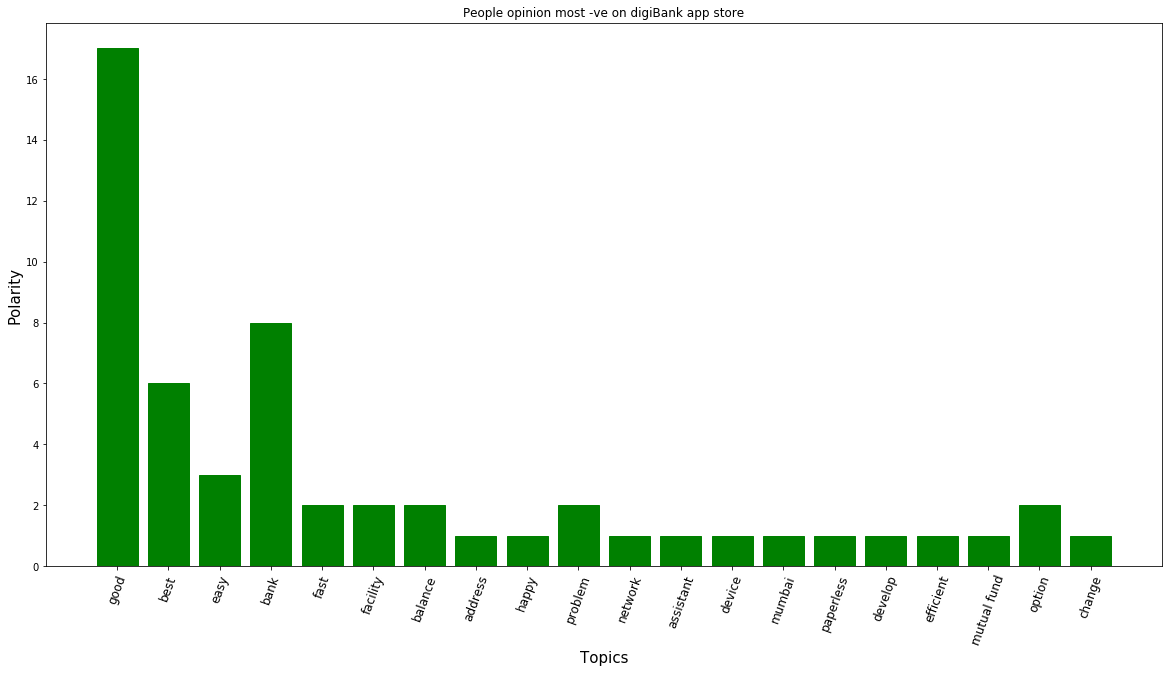

In [149]:
from showBarGraph import *
# show positive bar graph
showBarCharForSentiment(sortedMostPos(l), pos=True)

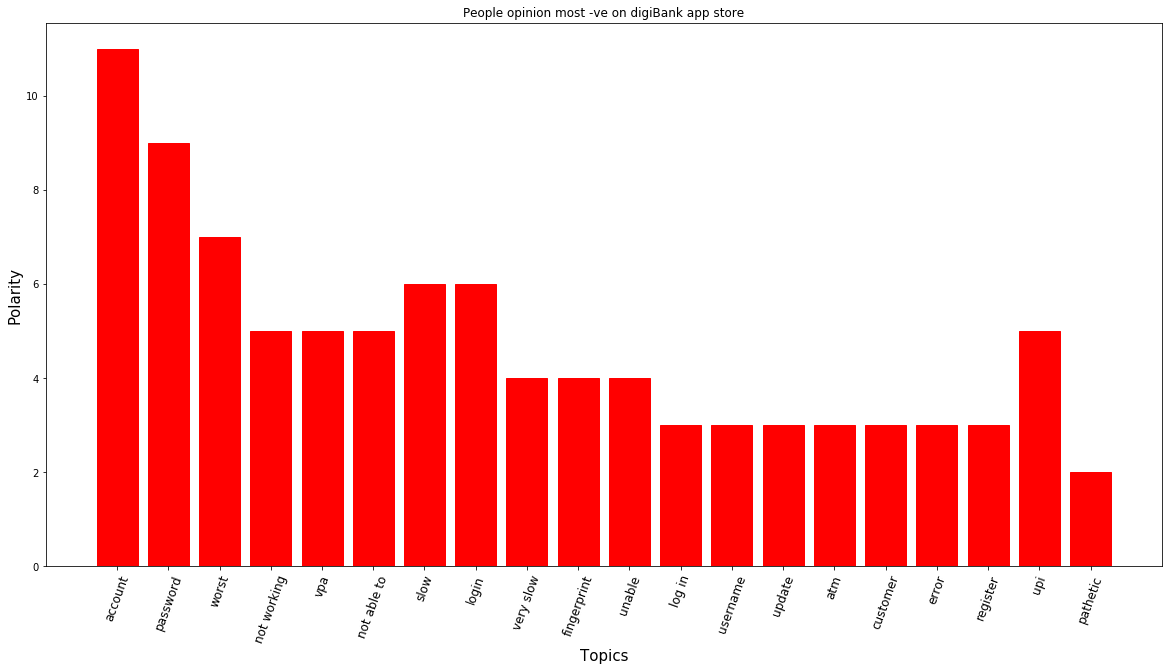

In [150]:
# print(sortedMostNeg(l))
# show positive bar graph
showBarCharForSentiment(sortedMostNeg(l), pos=False)

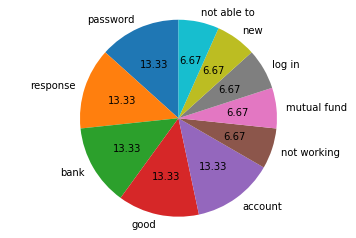

In [142]:
showPiChart(sortedMostFreq(l))

In [144]:
# showTempBarChart()